In [1]:
#imports
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import * 
from fastai.vision.widgets import *

#Takes my Microsoft Azure key to do a Bing image search
key = os.environ.get('AZURE_SEARCH_KEY', '1f7f35f1b5c3477ab06e450919fc5560')

#creating a list of search terms for Bing
vehicle_types = 'cars','police cars','trucks'
#Path function creates a folder to store all the different vehicles
path = Path('Vehicles')

if not path.exists():
    path.mkdir()
    #iterates over all the desired vehicle types
    for o in vehicle_types:
        
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        #using the "search_images_bing function"
        #takes my Microsoft Azure key, a term, minimum picture size,
        #and maximum imgages (128 and 150 defaults respsectively)
        results = search_images_bing(key, f'{o}')
        #returns the URLs pointing to each image
        download_images(dest, urls=results.attrgot('contentUrl'))
        #download_images function takes in the path to store the image,
        #and the URL in results. then downloads the images

In [2]:
#To verify all images are not corrupt and all are linked to a path
#-----------------------------------------
#gets all the downloaded images 
fns = get_image_files(path)
#uses a verify_images function to make sure each image downloaded
#is actually an image
failed = verify_images(fns)
#if not then this function failed.map will delete it
failed.map(Path.unlink);

In [3]:
#first part: tell Fast.AI what type of data we have
#and how its structured

#using the DataBlock API
#"blocks" provides a Tuple
    #takes in the independent variables ("ImageBlock")
    #the dependent variable ("CategoryBlock")
    #where ImageBlock = the images downloaded
    #where CategoryBlock = cars, police cars, trucks
vehicles = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    #how to get those images "get_items"
    #tell it the function to use
    #we used the "get_image_files"
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    #how to split the data into a:
    #a validation and training set
    #"RandomSplitter" randomly splits the data
    #20% for validation set
    #"seed" = each time its run, validation set is same
    get_y=parent_label,
    #how is the data labeled
    #"parent_label" looks at the folder the image is in
    item_tfms=Resize(128))
    #item_transforms. each is resized to a 128x128 size

In [4]:
vehicles = vehicles.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = vehicles.dataloaders(path)
#"dataloader" takes a certain amount of blocks from 
#imageblock and passes them in to be trained by the model
#allows the GPU to be faster

In [5]:
#training the model
#CNN_learner creates the model
#resenet18 has 18 layers in architecture
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.568771,0.339292,0.134831,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.575445,0.208134,0.089888,00:12
1,0.418938,0.177036,0.078652,00:12
2,0.357028,0.197980,0.078652,00:11
3,0.310812,0.218151,0.067416,00:11


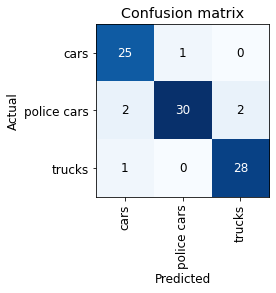

In [6]:
#how well did it do?
#confusion matrix
#how many were correctly predicted versus wrong
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

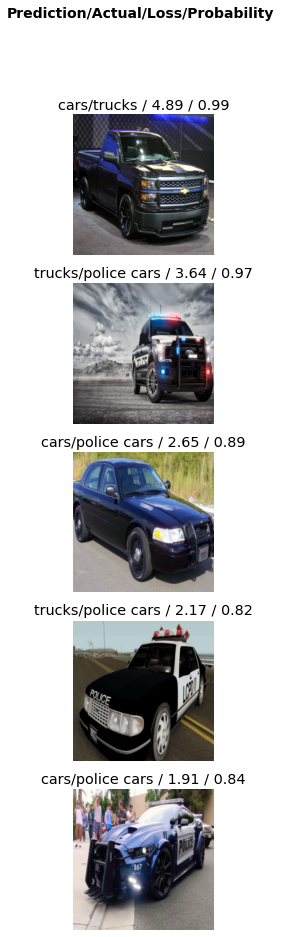

In [7]:
#find the top losses of images
#these will return the images that the model is either
#wrong or not confident in
#helps determine if an image obtained is just wrong
#(if it was labeled wrong)
interp.plot_top_losses(5, nrows=5)

In [27]:
learn.export()
#exporting the model
#contains all of the architecture and the parameters
#of the model
path = Path()
path.ls(file_exts = '.plk')

(#0) []

In [28]:
#to call the trained model
#and predict a new image
learn_inf = load_learner(path/'export.pkl')
#output: gives a tensor of all the prediction values
#for each label
prediction = learn_inf.predict(img)

#prints out the output
prediction

('police cars', TensorImage(1), TensorImage([0.0011, 0.9966, 0.0024]))

In [10]:
#returns imagaes in a GUi with highest loss
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
#deletes the images that are marked for deletion in GUI
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [15]:
uploader = widgets.FileUpload()
#creates an uploader widget to upload an image
uploader

FileUpload(value={}, description='Upload')

In [17]:
#creates the image variable "img" of my uploaded picture
img = PILImage.create(uploader.data[-1])

In [20]:
#output widget 
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))

#the output as a 128x128 picture
out_pl

Output()

In [21]:
#can add a text prompt for the label
prompt = widgets.Label()
prompt.value = 'Please Choose an Image'
prompt

Label(value='Please Choose an Image')

In [22]:
#create a button that when pressed classifies the image
classify_button = widgets.Button(description='Classify')
classify_button
#needs an event handler
#a function that activates once the button is pressed

Button(description='Classify', style=ButtonStyle())

In [23]:
#event handler
def on_click_classify(change):
    img= PILImage.create(uploader.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    prompt.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

classify_button.on_click(on_click_classify)

In [24]:
#putting into 1 widget
VBox([widgets.Label('Select your vehicle'),
      uploader,classify_button,out_pl,prompt])
#these GUI buttons reference the same above
#so when these change, so do the ones above

In [25]:
#to turn the notebook into an app anyone can use
#download free software Voila
!pip install voila
!jupyter serverextension enable voila --sys-prefix
#this makes it so they can only interact with the GUI
# and not see any of the other lines of code

  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.4 OK
